In this notebook, we will build a Vision Transformers approach (ViT) that is trying to answer, given a query image and a set of candidate images, which images are the most similar to the query image.

## Some history

Traditional approaches to deep learning for computer vision primarily revolve around convolutional neural networks (CNNs). However, with the introduction of the transformer architecture by Vaswani et al. (2017) for natural language processing tasks, researchers began to explore its application in the field of computer vision.



The Vision Transformer (ViT) is one of the first attempts to directly apply a transformer to image classification tasks. Instead of using CNNs to extract local features from images, ViT treats images as a sequence of patches, much like a transformer treats text as a sequence of words or subwords.



## The Dataset

We will use a dataset from hugging face: called beans to search a query bean in a set of beans and we will display the "closest" candidates

In [4]:
from datasets import load_dataset
dataset=load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /Users/cherifbenham/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
dataset["train"]

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the images
img1 = Image.open(dataset["train"]["image_file_path"][0])
img2 = Image.open(dataset["train"]["image_file_path"][1])

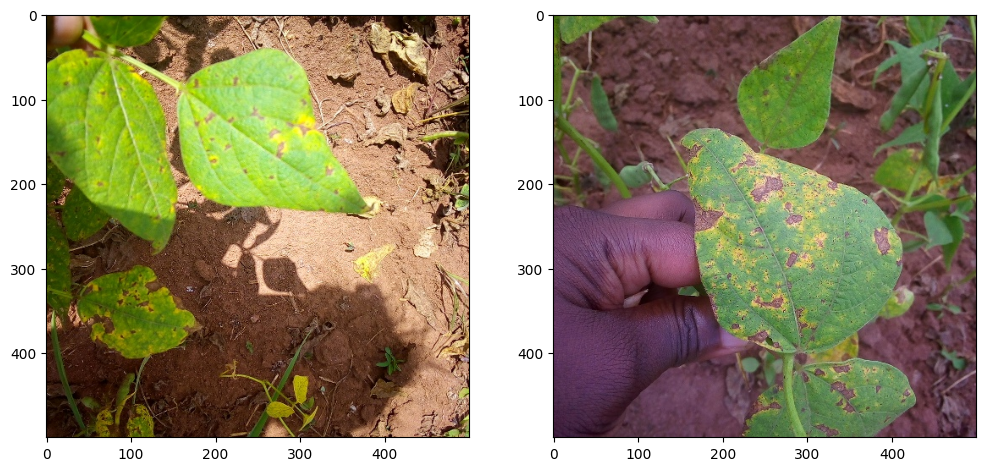

In [22]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the size as necessary

# Show the images
ax1.imshow(img1)
ax2.imshow(img2)


## The candidates dataset

To demonstrate the image similarity system, we'll use 100 samples from the candidate image dataset to keep the overall runtime short.



In [26]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

## Embeddings

We'll use **embeddings** to represent images in vector space. This gives us a nice way to meaningfully compress the high-dimensional pixel space of images (224 x 224 x 3, for example) to something much lower dimensional (768, for example). The primary advantage of doing this is the reduced computation time in the subsequent steps as well as removing the pixel-by-pixel comparison approach (embeddings from transformers should encompass the meanings behind an image regardless of the order of the pixels)

In [31]:
import torch 

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


To compute the embeddings from the images, we'll use a vision model that has some understanding of how to represent the input images in the vector space. This type of model is also commonly referred to as image encoder.

For loading the model, we leverage the AutoModel class. It provides an interface for us to load any compatible model checkpoint from the Hugging Face Hub. Alongside the model, we also load the processor associated with the model for data preprocessing.



In [ ]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
